# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


In [2]:
!pip install dataclasses
!pip install matplotlib

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [3]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from dataclasses import dataclass

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
class ReplayBuffer:
    """
    Replay Buffer Implementation
    :arg [max_size]: buffer max size
    :arg [input_shape]: shape of trajectory
    :arg [n_actions]: number of actions allowed by the env
    """
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)
        

        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.randint(0, max_mem, size=batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

In [8]:
class CriticNetwork(nn.Module):
    def __init__(self, critic_lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        self.q = nn.Linear(self.fc2_dims, 1)

        # Apply Xavier initialization to weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.action_value.weight)
        nn.init.xavier_uniform_(self.q.weight)

        # Initialize biases to zero
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()
        self.action_value.bias.data.zero_()
        self.q.bias.data.zero_()

        self.optimizer = optim.Adam(self.parameters(), lr=critic_lr, weight_decay=0.)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        state_action_value = self.q(state_action_value)

        return state_action_value

In [9]:
class ActorNetwork(nn.Module):
    def __init__(self, actor_lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super().__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        # Apply Xavier initialization to weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.mu.weight)

        # Initialize biases to zero
        self.fc1.bias.data.zero_()
        self.fc2.bias.data.zero_()
        self.mu.bias.data.zero_()

        self.optimizer = optim.Adam(self.parameters(), lr=actor_lr)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

In [10]:
class OUActionNoise:
    def __init__(self, mu=0.0, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x

        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

In [11]:
class DDPGAgent():
    def __init__(self, config):
        self.actor_lr = config.actor_lr
        self.critic_lr = config.critic_lr
        self.input_dims = config.input_dims
        self.tau = config.tau
        self.n_actions = config.n_actions
        self.gamma = config.gamma
        self.mem_size = config.mem_size
        self.epsilon = config.epsilon
        self.epsilon_decay = config.epsilon_decay
        self.fc1_dims = config.fc1_dims
        self.fc2_dims = config.fc2_dims
        self.batch_size = config.batch_size

        self.memory = ReplayBuffer(self.mem_size, self.input_dims, self.n_actions)

        self.noise = OUActionNoise(mu=np.zeros(self.n_actions))

        self.actor = ActorNetwork(self.actor_lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                n_actions=self.n_actions)
        self.critic = CriticNetwork(self.critic_lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                n_actions=self.n_actions)

        self.target_actor = ActorNetwork(self.actor_lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                n_actions=self.n_actions)

        self.target_critic = CriticNetwork(self.critic_lr, self.input_dims, self.fc1_dims, self.fc2_dims,
                                n_actions=self.n_actions)

        self.update_network_parameters(tau=1)
        
    def save(self, model_prefix):
        T.save(
        {
            'local_actor': self.actor.state_dict(),
            'target_actor': self.target_actor.state_dict(),
            'local_critic': self.critic.state_dict(),
            'target_critic': self.target_critic.state_dict(),
        },
        f'./{model_prefix}.pt')

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        mu = self.actor.forward(state).to(self.actor.device)
        if np.random.rand() < self.epsilon:
            mu_prime = mu + T.tensor(self.noise(), dtype=T.float).to(self.actor.device)
        else:
            mu_prime = mu

        self.actor.train()
        
        self.epsilon *= self.epsilon_decay
        
        return mu_prime.cpu().detach().numpy()[0]

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            print('GATHERING DATA')
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done.astype(np.uint8)).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)
        
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        T.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)

In [12]:
@dataclass
class AgentConfig:
    actor_lr: float
    critic_lr: float
    tau: float
    n_actions: int 
    input_dims: tuple
    gamma: float
    mem_size: int
    batch_size: float
    epsilon: float
    epsilon_decay: float
    fc1_dims: int
    fc2_dims: int

In [13]:
def launcher(env, actions, episodes=100, model_prefix='model'):
    brain_name = env.brain_names[0]  # Get the brain_name from the environment
    env_info = env.reset(train_mode=True)[brain_name]
    observation_shape = env_info.vector_observations[0].shape

    agent_config = AgentConfig(
        actor_lr=1e-4,
        critic_lr=1e-3,
        tau=1e-3,
        n_actions=actions,
        input_dims=tuple(observation_shape),
        gamma=0.99,
        mem_size=int(1e6),
        batch_size=256,
        epsilon=1.0,
        epsilon_decay=1e-6,
        fc1_dims=256,
        fc2_dims=256
    )

    agent = DDPGAgent(config=agent_config)

    scores = []
    best_score = -np.inf
    global_timestep = 0
    for episode in range(episodes):
        score = 0
        done = False
        env_info = env.reset(train_mode=True)[brain_name]
        observation = env_info.vector_observations[0]
        local_timestep = 0
        while not done:
            action = agent.choose_action(observation)
            env_info = env.step(action)[brain_name]
            observation_ = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]

            score += reward
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()

            observation = observation_
            global_timestep += 1
            local_timestep += 1

        scores.append(score)
        avg_score = np.mean(scores[-100:])  # Calculate the average score over the last 100 episodes

        if avg_score > best_score:
            agent.save(model_prefix)
            best_score = avg_score

        print(f"Episode: {episode}, Best score: {best_score}, Avg score: {avg_score}, Global timestep: {global_timestep}")

    return scores

In [14]:
def plot_scores(scores, output_file=None):
    episodes = len(scores)
    x = np.arange(1, episodes + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(x, scores, linewidth=2, marker='o', markersize=6, linestyle='-')

    plt.title("Agent's Performance over Episodes", fontsize=18, fontweight='bold')
    plt.xlabel('Episodes', fontsize=14, fontweight='bold')
    plt.ylabel('Scores', fontsize=14, fontweight='bold')

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    else:
        plt.show()

GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING DATA
GATHERING 

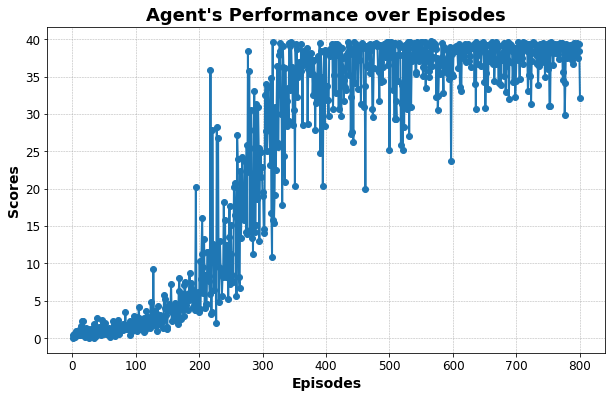

In [15]:
scores1 = launcher(env, actions=action_size, episodes=800, model_prefix='first_model')
plot_scores(scores1, output_file='first_agent_performance_plot.png')

In [16]:
np.save('first_scores.npy', scores1)

In [ ]:
env.close()